In [1]:
%matplotlib inline

# Imports

In [2]:
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import roc_auc_score, classification_report,\
                    confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

# Read in / set-up data

The relevant file/s should have been constructed from the `start_folding_energies.ipynb` file

In [317]:
start_df = pd.read_csv('../Data/ecoli_folding_energies.tsv', sep='\t')
start_df.head()

,locus_tag,ATG_index,location,within_frame,Unconstrained_mfe,Unconstrained_ensemble,Constrained_mfe,Constrained_ensemble
0,b0001,0,primary,NaN,-4.30,-2.0,-1.61,-0.60
1,b0002,0,primary,NaN,-20.68,-18.1,-11.80,-10.50
2,b0002,37,internal,False,-29.91,-27.0,-17.47,-14.90
3,b0002,79,internal,False,-43.35,-40.8,-29.42,-27.90
4,b0002,147,internal,True,-22.77,-20.5,-11.05,-10.35


In [318]:
#sklearn categorical variables should(need?) to be hard coded to 0 or 1 (dummy variables)
start_df['True_positive'] = 0
start_df.at[start_df[start_df['location']=='primary'].index, 'True_positive'] = 1

**Combine with the SD binding dataframe**

In [319]:
#Now let's grab the SD_df
start_sd_df = pd.read_csv('../Data/ecoli_sd_energies.tsv', sep='\t')
assert start_df.shape[0] == start_sd_df.shape[0]
start_sd_df.head()

,locus_tag,ATG_index,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,b0001,0,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.08,-0.17,...,-2.46,-1.82,-0.51,-0.09,-0.00,-0.01,-0.01,-0.01,-0.02,-0.02
1,b0002,0,-0.01,-0.01,-0.08,-1.59,-2.18,-5.12,-5.42,-4.85,...,-0.11,-1.59,-2.18,-2.52,-2.52,-1.96,-0.11,-0.01,-0.30,-0.41
2,b0002,37,-1.57,-1.66,-1.38,-0.29,-0.25,-0.10,-0.00,-0.00,...,-1.77,-1.88,-4.34,-3.96,-1.76,-1.58,-1.25,-0.19,-0.26,-0.64
3,b0002,79,-0.48,-3.40,-3.40,-3.40,-2.74,-1.07,-0.03,-0.00,...,-0.44,-0.44,-0.47,-0.34,-0.08,-0.13,-0.13,-0.19,-0.20,-0.27
4,b0002,147,-4.24,-3.87,-1.74,-1.57,-1.07,-0.03,-0.00,-0.00,...,-0.01,-0.01,-0.01,-0.00,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01


In [320]:
start_df = pd.merge(start_df, start_sd_df,  how='left',\
                    left_on=['locus_tag', 'ATG_index'], right_on = ['locus_tag', 'ATG_index'])
start_df.head()

,locus_tag,ATG_index,location,within_frame,Unconstrained_mfe,Unconstrained_ensemble,Constrained_mfe,Constrained_ensemble,True_positive,0,...,10,11,12,13,14,15,16,17,18,19
0,b0001,0,primary,NaN,-4.30,-2.0,-1.61,-0.60,1,-0.01,...,-2.46,-1.82,-0.51,-0.09,-0.00,-0.01,-0.01,-0.01,-0.02,-0.02
1,b0002,0,primary,NaN,-20.68,-18.1,-11.80,-10.50,1,-0.01,...,-0.11,-1.59,-2.18,-2.52,-2.52,-1.96,-0.11,-0.01,-0.30,-0.41
2,b0002,37,internal,False,-29.91,-27.0,-17.47,-14.90,0,-1.57,...,-1.77,-1.88,-4.34,-3.96,-1.76,-1.58,-1.25,-0.19,-0.26,-0.64
3,b0002,79,internal,False,-43.35,-40.8,-29.42,-27.90,0,-0.48,...,-0.44,-0.44,-0.47,-0.34,-0.08,-0.13,-0.13,-0.19,-0.20,-0.27
4,b0002,147,internal,True,-22.77,-20.5,-11.05,-10.35,0,-4.24,...,-0.01,-0.01,-0.01,-0.00,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01


**Add in a minimum column and drop the rest for the SD**

In [321]:
start_df['min_SD'] = start_df[['4', '5', '6', '7','8']].min(axis=1)
start_df = start_df.drop([str(i) for i in range(20)], axis=1)

**Make a new column that compares the unconstrained to constrained values**

In [322]:
###Normalized difference
# start_df['mfe_diff'] = (start_df['Unconstrained_mfe']-start_df['Constrained_mfe'])\
#                     /start_df['Unconstrained_mfe']

###Or not normalized (works better, I think)
start_df['mfe_diff'] = (start_df['Unconstrained_mfe']-start_df['Constrained_mfe'])

**Drop from further analysis all internal ATG's in the first or last X nt's**

I believe that this can prevent *some* "True Positives" from creeping into our analysis as mis-classified "True Negatives". Some start codons might be mis-annotated (and ergo some "internal" ATG's in the beginning of genes might in fact be the "primrary"!), and some ATG's towards the end of genes might be true starts for downstream genes. While not perfect... I feel like removing these from consideration can help a bit and doesn't dramatically cut the data set down.

There will of course still be some "True Negatives" in our "True Positives" category but we do not have the means to identify these without any more information. A conservative way, however, might be to discard any "primary" ATG's that have a corresponding in-frame internal ATG within the first X nt's. Again, this could limit some contamination of our categories but since our "primary" start codons are limited this really kills our sample size.

In [323]:
gene_df = pd.read_csv('../Data/ecoli_gene_df.tsv', sep='\t', index_col=0)
gene_df.head()

,start,stop,strand
b0001,189,255,1
b0002,336,2799,1
b0003,2800,3733,1
b0004,3733,5020,1
b0005,5233,5530,1


In [324]:
#Remove "primary" ATG's if they have an in-frame ATG within the boundary
#I hesitate to do this since it will cut our true positives down a lot
# drop_boundary = 50
# to_drop = []
# for locus in gene_df.index[:]:
#     temp = start_df[(start_df['locus_tag']==locus)]
#     if len(temp[(temp['ATG_index']<drop_boundary)\
#                 &(temp['within_frame'])==True].index) > 0:
#         to_drop.extend(temp[temp['location']=='primary'].index)
# start_df = start_df.drop(to_drop)

In [325]:
#Remove "internal" ATG's if they occur near the gene boundaries
drop_boundary = 50
to_drop = []
for locus in gene_df.index:
    locus_len = gene_df.at[locus, 'stop'] - gene_df.at[locus, 'start']
    temp = start_df[(start_df['locus_tag']==locus)&(start_df['location']!='primary')]
    
    to_drop.extend(temp[(temp['ATG_index']<drop_boundary)&\
                       (temp['within_frame'])==True].index) ###Only drop in-frame 5'
    
    to_drop.extend(temp[(temp['ATG_index']>locus_len-drop_boundary)].index) ###Drop 3' regardless of frame
start_df = start_df.drop(to_drop)

print(start_df.shape,\
      start_df[start_df['location']=='primary'].shape,\
      start_df[start_df['location']=='internal'].shape)

(72509, 11) (3830, 11) (68679, 11)


# Make exploratory plots

Ttest_indResult(statistic=67.16926476468113, pvalue=0.0)
RanksumsResult(statistic=60.435123043835304, pvalue=0.0)


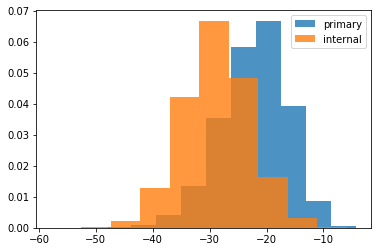

In [326]:
coi = 'Unconstrained_mfe'
# coi = 'Unconstrained_ensemble'
# coi = 'mfe_diff'
# coi = 'min_SD'


a = start_df[start_df['True_positive']==1][coi]
b = start_df[start_df['True_positive']==0][coi]


fig, ax = plt.subplots()
ax.hist(a, density=True, alpha=0.8, label='primary')
ax.hist(b, density=True, alpha=0.8, label='internal')
ax.legend()
print(stats.ttest_ind(a,b))
print(stats.ranksums(a,b))

**Area under the ROC**

In [327]:
coi = 'Unconstrained_mfe'
y_true = start_df['True_positive']
y_scores = start_df[coi]
print(roc_auc_score(y_true, y_scores))

0.7896585629357479


In [328]:
coi = 'mfe_diff'
y_true = start_df['True_positive']
y_scores = start_df[coi]
print(roc_auc_score(y_true, y_scores))

0.7733944634472165


In [329]:
coi = 'min_SD'
y_true = start_df['True_positive']
y_scores = 1 - start_df['min_SD']
print(roc_auc_score(y_true, y_scores))

0.8788576758330473


# Diving in to sklearn

**More data preparation**

In [330]:
#We're going to use the data (and only the data) in X to predict Y
# X = start_df.drop(['locus_tag', 'location', 'within_frame', 'ATG_index', 'True_positive'], axis=1)
# X = start_df.drop(['locus_tag', 'location', 'within_frame', 'ATG_index', 'True_positive',\
#                   'Unconstrained_ensemble', 'Constrained_ensemble', 'Unconstrained_mfe'], axis=1)
X = start_df.drop(['locus_tag', 'location', 'within_frame', 'ATG_index', 'True_positive',\
                  'Unconstrained_ensemble', 'Constrained_ensemble', 'Constrained_mfe'], axis=1)
# X = start_df.drop(['locus_tag', 'location', 'within_frame', 'ATG_index', 'True_positive',\
#                   'Unconstrained_ensemble', 'Constrained_ensemble', 'mfe_diff'], axis=1)
Y = start_df['True_positive']

In [331]:
X.head()

,Unconstrained_mfe,min_SD,mfe_diff
0,-4.30,-2.24,-2.69
1,-20.68,-5.42,-8.88
2,-29.91,-0.25,-12.44
3,-43.35,-2.74,-13.93
4,-22.77,-1.07,-11.72


**Need to separate my training and testing data**

In [332]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, stratify=Y)

In [333]:
X_train.head()

,Unconstrained_mfe,min_SD,mfe_diff
12248,-27.03,-2.65,-17.63
76991,-27.73,-0.05,-8.57
75461,-23.48,-0.75,-9.96
31817,-20.94,-0.38,-6.75
64797,-27.04,-1.60,-11.49


In [334]:
Y_train.head()

12248    0
76991    0
75461    0
31817    0
64797    0
Name: True_positive, dtype: int64

# Fit a model to the training data

**Lots of options here. Which is best? You'd have a multi-million dollar salary at google if you could answer that definitively. Fitting may take a lot of time depending on the method**

**Initial playing around tells me that class imbalances are going to be important to consider. Which is to say, we have many more true negatives (internal not-start codons) than we do true positives (actual start codons). This will affect the ability of a model to accurately discriminate between the two without some tuning**

In [335]:
###Random forest is a good (and fast starting point). But beware class imbalances!
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=200, max_depth=5,\
                                    class_weight='balanced_subsample')
classifier.fit(X_train, Y_train)

# #SVM is another VERY common option to consider. Again, should probably include class
# #probabilities which takes longer
# from sklearn.svm import SVC
# # classifier = SVC(kernel='rbf')
# classifier = SVC(kernel='rbf', class_weight='balanced', probability=True)
# # classifier = SVC(kernel='rbf', probability=True)
# classifier.fit(X_train, Y_train)

###Good old logistic regression
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',\
#                                 class_weight='balanced')
# classifier.fit(X_train, Y_train)


###Boosted trees frequently outcompete random forest classifiers but it can be tricky
# from sklearn.ensemble import GradientBoostingClassifier
# classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1,\
#                                         random_state=0)
# classifier.fit(X_train, Y_train)

# from sklearn.gaussian_process import GaussianProcessClassifier
# classifier = GaussianProcessClassifier(random_state=0)
# classifier.fit(X_train, Y_train)

# from sklearn.neighbors import KNeighborsClassifier
# classifier = KNeighborsClassifier(n_neighbors=40)
# classifier.fit(X_train, Y_train) 

# from sklearn.neural_network import MLPClassifier
# classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
# classifier.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Evaluate how we did

(I need to check into what the `classifier.score` is and whether we can change it).

But the important thing is that ideally there isn't a *huge* dropoff between score on the training and testing data (this would happen if we overfit to the training data). But a drop is natural to see.

In [336]:
classifier.score(X_train, Y_train), classifier.score(X_test, Y_test)

(0.9007016394573069, 0.9008412632740311)

**Look at the confusion matrix and classification reports**

In [337]:
test_pred = classifier.predict(X_test)
print(confusion_matrix(Y_test, test_pred))
print(classification_report(Y_test,test_pred))

[[12413  1323]
 [  115   651]]
             precision    recall  f1-score   support

          0       0.99      0.90      0.95     13736
          1       0.33      0.85      0.48       766

avg / total       0.96      0.90      0.92     14502



**To get an ROC score you need to convert from binary classification (yes/no) to a probability of being yes or no. With those probabilites, we can run an ROC test. Note: some fitting methods used above will not output a probability score or do so by default**

In [338]:
test_prob = classifier.predict_log_proba(X_test)
a, b = zip(*test_prob)
test_prob = b
print(roc_auc_score(Y_test, test_prob))

0.943526549130109


**Some methods let you look at how important different features are/were**

In [339]:
# classifier.feature_importances_
# classifier.get_params()
# classifier.coef_

0.6542236776674364


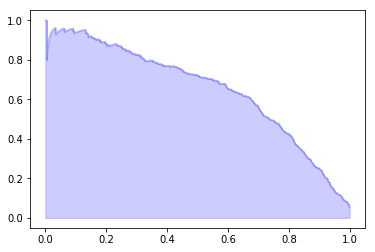

In [340]:
precision, recall, thresholds = precision_recall_curve(Y_test, test_prob)
fig, ax = plt.subplots()
ax.step(recall, precision, color='b', alpha=0.2,
         where='post')
ax.fill_between(recall, precision, alpha=0.2, color='b')
print(average_precision_score(Y_test, test_prob))

# Visualizing start codon probabilities

In [341]:
probs = classifier.predict_proba(X)

In [342]:
start_df['predictions'] = probs[:,1]

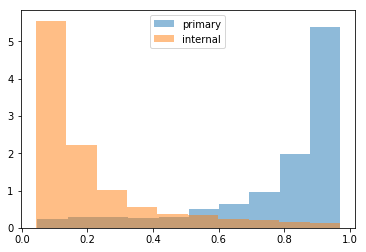

In [254]:
fig, ax = plt.subplots()
ax.hist(start_df[start_df['location']=='primary']['predictions'], density=True, alpha=0.5, label='primary')
ax.hist(start_df[start_df['location']=='internal']['predictions'], density=True, alpha=0.5, label='internal')
ax.legend()
# ax.hist(start_df[(start_df['location']=='internal') &\
#                 (start_df['ATG_index']<10)]['predictions'], density=True, alpha=0.5)


/Users/adamhockenberry/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/lib/histograms.py:815: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/adamhockenberry/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:4971: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


nan
0.3977716305191304
RanksumsResult(statistic=nan, pvalue=nan)


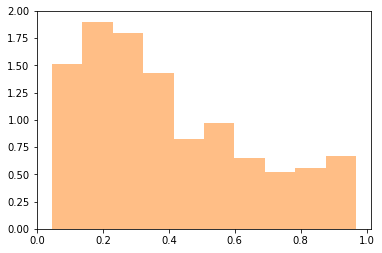

In [107]:
delim = 20
fig, ax = plt.subplots()

ax.hist(start_df[(start_df['location']=='internal') &\
                 (start_df['within_frame']==True) &\
                 (start_df['ATG_index']<delim)]['predictions'], density=True, alpha=0.5)
ax.hist(start_df[(start_df['location']=='internal') &\
                 (start_df['within_frame']==False) &\
                 (start_df['ATG_index']<delim)]['predictions'], density=True, alpha=0.5)
print(start_df[(start_df['location']=='internal') &\
                 (start_df['within_frame']==True) &\
                 (start_df['ATG_index']<delim)]['predictions'].mean())
print(start_df[(start_df['location']=='internal') &\
                 (start_df['within_frame']==False) &\
                 (start_df['ATG_index']<delim)]['predictions'].mean())
print(stats.ranksums(start_df[(start_df['location']=='internal') &\
                 (start_df['within_frame']==True) &\
                 (start_df['ATG_index']<delim)]['predictions'],\
                start_df[(start_df['location']=='internal') &\
                 (start_df['within_frame']==False) &\
                 (start_df['ATG_index']<delim)]['predictions']))

# Interrogating individual genes

In [48]:
start, stop, strand = gene_df.loc['b2971']
print(stop-start)

411


In [ ]:
(903-720) / 3

In [ ]:
# start_df[(start_df['location']=='primary') &\
#                   (start_df['predictions']>0.80)]
start_df[(start_df['location']=='internal') &\
                 (start_df['within_frame']==True) & (start_df['predictions']>0.90)]
# start_df[(start_df['location']=='primary') &\
#                  (start_df['predictions']>0.90)]

In [ ]:
start_df[start_df['locus_tag'] == 'b2971']

# Scratch

**Hyperparameter optimization**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
params_rf = {'bootstrap': [True, False],\
             'class_weight':['balanced', 'balanced_subsample'],\
             'n_estimators': [100, 200, 400],\
             'max_depth': [4, 5, 6, 7, 8, 9, 10]}
#use gridsearch to test all values for n_estimators
# rf_gs = GridSearchCV(rf, params_rf, cv=5)
rf_gs = GridSearchCV(rf, params_rf, scoring='average_precision', cv=5)

#fit model to training data
rf_gs.fit(X_train, Y_train)

#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)
print(rf_best.score(X_test, Y_test))

In [ ]:
test_prob = rf_best.predict_proba(X_test)
a, b = zip(*test_prob)
test_prob = b
print(roc_auc_score(Y_test, test_prob))

In [ ]:
precision, recall, thresholds = precision_recall_curve(Y_test, test_prob)
fig, ax = plt.subplots()
ax.step(recall, precision, color='b', alpha=0.2,
         where='post')
ax.fill_between(recall, precision, alpha=0.2, color='b')
print(average_precision_score(Y_test, test_prob))

**SVM**

In [ ]:
from sklearn.svm import SVC


#create a new random forest classifier
svm = SVC()
#create a dictionary of all values we want to test for n_estimators
params_svm = {'class_weight':['balanced'],\
              'kernel':['poly', 'sigmoid', 'rbf'],\
              'C': [0.001, 0.01, 0.1, 1.0, 10]}
#use gridsearch to test all values for n_estimators
svm_gs = GridSearchCV(svm, params_svm, cv=5)
#fit model to training data
svm_gs.fit(X_train, Y_train)

#save best model
svm_best = svm_gs.best_estimator_
#check best n_estimators value
print(svm_gs.best_params_)
print(svm_best.score(X_test, Y_test))

**Logistic regression**

In [ ]:
#create a new logistic regression model
from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression()



params_log_reg = {'class_weight':['balanced'],\
             'penalty': ['l1', 'l2'],\
                 'C': [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.]}
#use gridsearch to test all values for n_estimators
log_reg_gs = GridSearchCV(log_reg, params_log_reg, cv=5)
#fit model to training data
log_reg_gs.fit(X_train, Y_train)

#save best model
log_reg_best = log_reg_gs.best_estimator_
#check best n_estimators value
print(log_reg_gs.best_params_)
print(log_reg_best.score(X_test, Y_test))

**Now vote!**

In [ ]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('rf', rf_best), ('log_reg', log_reg_best)]
#create our voting classifier, inputing our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble.fit(X_train, Y_train)
#test our model on the test data
ensemble.score(X_test, Y_test)

**Ignoring machine learning complications and thinking about mixed linear models. The advantage is the ability to include fixed/random effects (intercepts/slopes) according to the different genes, the disadvantage is (of course) linearity requirements**

In [80]:
import statsmodels.formula.api as smf

In [345]:
md = smf.mixedlm("I(True_positive) ~ min_SD + Unconstrained_ensemble + mfe_diff", start_df, groups=start_df['locus_tag'])
mdf = md.fit(reml=False)

/Users/adamhockenberry/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [346]:
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:               MixedLM  Dependent Variable:  I(True_positive)
No. Observations:    72509    Method:              ML              
No. Groups:          4229     Scale:               0.0370          
Min. group size:     1        Likelihood:          16630.9391      
Max. group size:     129      Converged:           Yes             
Mean group size:     17.1                                          
-------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept               0.225    0.003   64.862 0.000  0.218  0.232
min_SD                 -0.060    0.000 -138.043 0.000 -0.060 -0.059
Unconstrained_ensemble  0.006    0.000   42.340 0.000  0.006  0.006
mfe_diff                0.009    0.000   37.570 0.000  0.009  0.010
Group Var               0.000    0.000                             
===================================================================

"""

In [347]:
start_df['predictions'] = mdf.fittedvalues

In [86]:
inframe_df = start_df[start_df['within_frame']!=False]

In [87]:
inframe_df.shape

(34347, 12)

In [94]:
choices = []
loci = []
for locus in set(inframe_df['locus_tag']):
    temp_df = inframe_df[inframe_df['locus_tag']==locus]
    if 'primary' in temp_df['location'].value_counts():

        #temp_df = temp_df.sort_values(by=['predictions'], ascending=False)
#         temp_df = temp_df.sort_values(by=['Unconstrained_mfe'], ascending=False)
#         temp_df = temp_df.sort_values(by=['min_SD'], ascending=True)
        temp_df = temp_df.sort_values(by=['mfe_diff'], ascending=False)


        choices.append(temp_df.iloc[0]['ATG_index'])
        loci.append(locus)
print(choices.count(0), len(choices))

2050 3830


In [92]:
temp_df.head()

,locus_tag,ATG_index,location,within_frame,Unconstrained_mfe,Unconstrained_ensemble,Constrained_mfe,Constrained_ensemble,min_SD,mfe_diff,True_positive,predictions
18851,b1074,276,internal,True,-26.75,-24.1,-18.18,-15.74,-3.64,-8.57,0,0.216143
18845,b1074,0,primary,NaN,-26.14,-24.5,-17.58,-15.89,-3.61,-8.56,1,0.211990
18854,b1074,315,internal,True,-28.70,-26.5,-15.89,-14.40,-2.74,-12.81,0,0.109047
18853,b1074,303,internal,True,-25.32,-23.1,-17.54,-16.10,-0.43,-7.78,0,0.038084


In [ ]:
for i,j in zip(loci, choices):
    if j > 0 and j < 10:
        print(i, j)

In [ ]:
len(choices)

In [ ]:
start_df['testy'].max()

# Suppose I have a model that made predictions...

In [348]:
start_df.head()

,locus_tag,ATG_index,location,within_frame,Unconstrained_mfe,Unconstrained_ensemble,Constrained_mfe,Constrained_ensemble,True_positive,min_SD,mfe_diff,predictions
0,b0001,0,primary,NaN,-4.30,-2.0,-1.61,-0.60,1,-2.24,-2.69,0.322431
1,b0002,0,primary,NaN,-20.68,-18.1,-11.80,-10.50,1,-5.42,-8.88,0.354483
2,b0002,37,internal,False,-29.91,-27.0,-17.47,-14.90,0,-0.25,-12.44,-0.040915
3,b0002,79,internal,False,-43.35,-40.8,-29.42,-27.90,0,-2.74,-13.93,0.009259
4,b0002,147,internal,True,-22.77,-20.5,-11.05,-10.35,0,-1.07,-11.72,0.054447


**How can I know how we did???**

In [367]:
# emp_df = pd.read_csv('/Users/adamhockenberry/Downloads/common_bw25113.txt', sep='\t')
# emp_df = pd.read_csv('/Users/adamhockenberry/Downloads/specific_bw25113.txt', sep='\t')
emp_df = pd.read_csv('/Users/adamhockenberry/Downloads/primary_bw25113.txt', sep='\t')
emp_df = emp_df[emp_df['Start Codon'] == 'ATG']
print(emp_df.shape)
emp_df.head()

(1465, 8)


,Type,Gene name,Start Codon,Amino acid length,Peak height BW25113,Start position in BW25113,Stop position in BW25113,Strand
0,Annotated,thrL,ATG,21,34.547993,190,255,+
1,Annotated,thrA,ATG,820,294.674061,337,2799,+
2,Annotated,thrC,ATG,428,7.316046,3734,5020,+
3,Annotated,talB,ATG,317,42.270486,8238,9191,+
4,Annotated,mog,ATG,195,89.824783,9306,9893,+


In [368]:
# emp_df = emp_df[emp_df['Type']!='Annotated']
# emp_df.shape

In [369]:
from Bio import SeqIO
genome_location = '../Data/ecoli.gb'
genome_type = 'genbank'
###Read genome
genome = list(SeqIO.parse(genome_location, genome_type))

###Good to double check. If this fails on a future genome we'll have to decide what to do
assert len(genome) == 1
genome = genome[0]

gene_to_locus = {}
seq_dict = {}
for feature in genome.features:
    if feature.type == 'CDS':
        ###Filter out the weirdos
        if 'pseudo' in feature.qualifiers or 'ribosomal_slippage' in feature.qualifiers:
            continue
        gene_to_locus[feature.qualifiers['gene'][0]] = feature.qualifiers['locus_tag'][0]
        seq_dict[feature.qualifiers['locus_tag'][0]] = feature.extract(genome.seq)

In [370]:
for index in emp_df.index:
    name = emp_df.at[index, 'Gene name']
    if '(' in name:
        name = name.split(' ')[-1][1:-1]
        
    locus = ''
    try:
        locus = gene_to_locus[name]
    except KeyError:
        pass
    emp_df.at[index, 'locus_tag'] = locus

In [371]:
emp_df.shape

(1465, 9)

In [372]:
emp_df = emp_df[emp_df['locus_tag'] != '']
emp_df.shape

(1389, 9)

In [373]:
vals = []
for index in emp_df.index:
    locus = emp_df.at[index, 'locus_tag']
    nt_len = emp_df.at[index, 'Amino acid length']*3
    gene_len = gene_df.at[locus, 'stop'] - gene_df.at[locus, 'start']
    nt_index = gene_len - nt_len - 3
    tempy = start_df[(start_df['locus_tag']==locus)&(start_df['ATG_index']==nt_index)]
    if len(tempy.index) == 1:
        vals.append(tempy.iloc[0]['predictions'])
    else:
        if nt_index < 50 or gene_df.at[locus, 'stop']-gene_df.at[locus, 'start'] - nt_index < 50:
            pass
        else:
            print(locus, nt_index, gene_df.at[locus, 'stop']-gene_df.at[locus, 'start'])

b3894 2463 3051
b0859 1041 1128
b1103 276 360
b2833 159 219
b3836 147 270
b2478 828 879
b2777 396 672
b3610 192 252


In [374]:
vals

[0.3224309641390488,
 0.3544832293296157,
 0.27812044219284165,
 0.2552774112335623,
 0.23873017469451696,
 0.4758194622689505,
 0.2039289721270735,
 0.2831085094912986,
 0.4693599412238021,
 0.46031244660486476,
 0.3142675603190924,
 0.31860806587661583,
 0.2792328216351449,
 0.45291291595864236,
 0.2831332868626032,
 0.29993416720408844,
 0.3969920350172268,
 0.30997178973353745,
 0.4037033839317009,
 0.3713728876912099,
 0.139244778595361,
 0.5895384704142057,
 0.36538674351873685,
 0.26883280154959205,
 0.3162468092505115,
 0.34672857363792964,
 0.30203352453379817,
 0.3588865383006713,
 0.36310786645130294,
 0.3798142026586697,
 0.19068038575323332,
 0.22589453982788393,
 0.029049050203451637,
 0.25634603048180366,
 0.5224305927421288,
 0.3755892451854841,
 0.3958349805573591,
 0.2015484550297911,
 0.40100075202419305,
 0.4721778922353595,
 0.3252288998322694,
 0.3034263332934261,
 0.4387948666959873,
 0.21074457223625426,
 0.3550891589333536,
 0.2912974857494256,
 0.3448527944225

RanksumsResult(statistic=8.986276480800823, pvalue=2.557480882347089e-19)
0.3377754600103025 0.30008648398981463


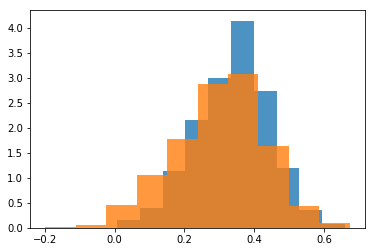

In [377]:
fig, ax = plt.subplots()
ax.hist(vals, density=True, alpha=0.8);
ax.hist(start_df[start_df['location']=='primary']['predictions'], density=True, alpha=0.8);
print(stats.ranksums(vals, start_df[start_df['location']=='primary']['predictions']))
print(np.mean(vals), np.mean(start_df[start_df['location']=='primary']['predictions']))

In [161]:
start_df[start_df['locus_tag']=='b2601']

,locus_tag,ATG_index,location,within_frame,Unconstrained_mfe,Unconstrained_ensemble,Constrained_mfe,Constrained_ensemble,min_SD,mfe_diff,True_positive,predictions
46245,b2601,0,primary,NaN,-14.39,-11.9,-10.44,-9.00,-4.07,-3.95,1,0.966696
46246,b2601,51,internal,True,-15.51,-12.1,-8.27,-6.37,-1.91,-7.24,0,0.779334
46247,b2601,173,internal,False,-30.23,-29.1,-17.89,-16.91,-0.12,-12.34,0,0.067768
46248,b2601,193,internal,False,-25.57,-24.0,-15.52,-13.95,-0.07,-10.05,0,0.110505
46249,b2601,217,internal,False,-25.07,-23.2,-14.35,-12.40,-0.05,-10.72,0,0.123711
46250,b2601,273,internal,True,-27.80,-25.7,-21.07,-20.47,-0.11,-6.73,0,0.187320
46251,b2601,339,internal,True,-23.28,-19.9,-14.85,-12.50,-0.45,-8.43,0,0.217177
46252,b2601,343,internal,False,-23.47,-20.4,-14.50,-12.90,-0.44,-8.97,0,0.180016
46253,b2601,355,internal,False,-26.39,-23.1,-15.90,-13.00,-4.58,-10.49,0,0.662566
46254,b2601,408,internal,True,-30.77,-28.4,-24.23,-22.30,-1.97,-6.54,0,0.381500


In [162]:
start, stop, strand = gene_df.loc['b2601']
stop-start

1071

In [185]:
emp_df

,Type,Gene name,Upsteam nucleotide sequence,Start Codon,Amino acid length,Peak height,Start Position,Stop Position,Strand,Relative density,locus_tag
1,In-frame,cueR,GAGCTGCAATCC,ATG,35,6.096705,514293,514400,+,0.143541,b0487
3,In-frame,ymgC,AGGGAGGTGTTC,ATG,58,13.819197,1216820,1216996,+,0.206061,b1167
4,In-frame,ymiA,GATGGCGATTAT,ATG,46,7.112822,1335148,1335288,+,0.339806,b4522
6,In-frame,yoaC,TGGGCAAAAAAA,ATG,27,6.503152,1894349,1894432,+,0.421053,b1810
8,In-frame,yffL,GGAGAATTTCTC,ATG,175,20.525573,2560371,2560898,+,0.687075,b2443
16,In-frame,intF,TGGAGCCGAAAA,ATG,441,58.731589,297021,295696,-,0.546314,b0281
19,In-frame,cutC,CAAGGATTGTCC,ATG,33,18.086891,1958621,1958520,-,0.502825,b1874
20,In-frame,yedR,GGTTATCTCAAA,ATG,100,20.322349,2033421,2033119,-,0.534759,b1963
21,In-frame,yfcO,TGGTTGGTTATT,ATG,143,12.803080,2449659,2449228,-,0.398734,b2332
24,In-frame,yfjH,TATGGTGGTTTT,ATG,291,10.161175,2758519,2757644,-,0.480769,b2623


**What about precision?**

In [344]:
start_df[start_df['location']=='internal'].sort_values(by='predictions', ascending=False)

,locus_tag,ATG_index,location,within_frame,Unconstrained_mfe,Unconstrained_ensemble,Constrained_mfe,Constrained_ensemble,True_positive,min_SD,mfe_diff,predictions
34642,b1978,34,internal,False,-16.51,-14.3,-13.72,-11.90,0,-6.41,-2.79,0.971883
40974,b2305,729,internal,True,-15.72,-13.4,-10.58,-9.00,0,-7.00,-5.14,0.971763
39762,b2243,4,internal,False,-16.34,-14.1,-12.07,-10.40,0,-8.62,-4.27,0.971633
41963,b2367,1396,internal,False,-11.00,-9.0,-6.22,-4.30,0,-6.51,-4.78,0.971421
17665,b1001,232,internal,False,-14.76,-10.9,-10.64,-8.60,0,-5.68,-4.12,0.969203
29832,b1692,4,internal,False,-16.32,-13.9,-10.87,-9.99,0,-6.51,-5.45,0.968406
68329,b3875,427,internal,False,-10.73,-8.1,-7.99,-6.97,0,-4.10,-2.74,0.966202
55282,b3121,1108,internal,False,-15.16,-12.8,-12.88,-10.34,0,-4.10,-2.28,0.966162
46706,b2628,415,internal,False,-9.55,-6.1,-6.47,-4.70,0,-4.24,-3.08,0.965556
20096,b1144,4,internal,False,-19.29,-16.1,-15.76,-14.20,0,-6.43,-3.53,0.965264
